<a href="https://colab.research.google.com/github/manyacodingworld/Receipe_finder/blob/master/BDA_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install PySpark in Google Colab
!pip install pyspark

# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.ml.fpm import FPGrowth
from pyspark.sql.functions import collect_list, col, size, explode, split, trim
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("Supermarket Basket Analysis") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

print("Spark Version:", spark.version)
print("Spark Session Created Successfully!")

Spark Version: 4.0.1
Spark Session Created Successfully!


In [2]:

from google.colab import files
uploaded = files.upload()


filename = list(uploaded.keys())[0]
print(f"Uploaded file: {filename}")

Saving Online_Retail_1.csv to Online_Retail_1.csv
Uploaded file: Online_Retail_1.csv


In [3]:
# Load the dataset into PySpark DataFrame
# Adjust the file path and options based on your dataset format

# For CSV files
df = spark.read.csv(filename, header=True, inferSchema=True)

# Display basic information
print("Dataset Shape:", (df.count(), len(df.columns)))
print("\nSchema:")
df.printSchema()
print("\nFirst 10 rows:")
df.show(10, truncate=False)

Dataset Shape: (541909, 8)

Schema:
root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)


First 10 rows:
+---------+---------+-----------------------------------+--------+----------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate     |UnitPrice|CustomerID|Country       |
+---------+---------+-----------------------------------+--------+----------------+---------+----------+--------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |01-12-2010 08:26|2.55     |17850     |United Kingdom|
|536365   |71053    |WHITE METAL LANTERN                |6       |01-12-2010 08:26|3.39     |17850     |United Kingdom|
|536365   

In [4]:
# Data Exploration
print("="*60)
print("DATA EXPLORATION")
print("="*60)

# Check for null values
from pyspark.sql.functions import col, sum as spark_sum
null_counts = df.select([spark_sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
print("\nNull values per column:")
null_counts.show()

# Basic statistics
print("\nDataset Statistics:")
df.describe().show()

# Count unique transactions
if 'InvoiceNo' in df.columns or 'Transaction' in df.columns or 'TransactionID' in df.columns:
    transaction_col = 'InvoiceNo' if 'InvoiceNo' in df.columns else ('Transaction' if 'Transaction' in df.columns else 'TransactionID')
    num_transactions = df.select(transaction_col).distinct().count()
    print(f"\nTotal Unique Transactions: {num_transactions}")

DATA EXPLORATION

Null values per column:
+---------+---------+-----------+--------+-----------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
|        0|        0|       1454|       0|          0|        0|    135080|      0|
+---------+---------+-----------+--------+-----------+---------+----------+-------+


Dataset Statistics:
+-------+------------------+------------------+--------------------+-----------------+----------------+-----------------+------------------+-----------+
|summary|         InvoiceNo|         StockCode|         Description|         Quantity|     InvoiceDate|        UnitPrice|        CustomerID|    Country|
+-------+------------------+------------------+--------------------+-----------------+----------------+-----------------+------------------+-----------+
|  count|            541909|            541909|          

In [5]:
# Data Preprocessing
print("="*60)
print("DATA PREPROCESSING")
print("="*60)

# Adjust column names based on your dataset
# Common column names:  InvoiceNo, Transaction, TransactionID for transaction IDs
# Description, ItemDescription, Product for product names

# Example preprocessing - modify based on your dataset structure
# Assuming columns: TransactionID and Product

# Remove null values
df_cleaned = df.na.drop()

# For datasets with separate rows per item
# Group items by transaction
transaction_col = 'InvoiceNo' if 'InvoiceNo' in df.columns else 'Transaction'
product_col = 'Description' if 'Description' in df.columns else 'Product'

# Clean product names (remove extra spaces, convert to lowercase)
df_cleaned = df_cleaned.withColumn(product_col, trim(col(product_col)))

# Remove cancelled transactions (if applicable)
if 'InvoiceNo' in df.columns:
    df_cleaned = df_cleaned.filter(~col('InvoiceNo').startswith('C'))

# Remove negative quantities (returns)
if 'Quantity' in df.columns:
    df_cleaned = df_cleaned.filter(col('Quantity') > 0)

print(f"\nRecords after cleaning:  {df_cleaned.count()}")

# Create transaction baskets with unique items
from pyspark.sql.functions import array_distinct # Import array_distinct
transactions = df_cleaned.groupBy(transaction_col) \
    .agg(array_distinct(collect_list(product_col)).alias("items"))

# Filter out transactions with only 1 item (need at least 2 for association)
transactions = transactions.filter(size(col("items")) > 1)

print(f"\nTransactions with multiple items: {transactions.count()}")
transactions.show(10, truncate=False)

DATA PREPROCESSING

Records after cleaning:  397924

Transactions with multiple items: 17130
+---------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|InvoiceNo|items                                                                                                                                                                                                                                                                                                                                                                                                

In [6]:
# Apply FP-Growth Algorithm for Association Rule Mining
print("="*60)
print("ASSOCIATION RULE MINING - FP-GROWTH")
print("="*60)

# Configure FP-Growth parameters
fpGrowth = FPGrowth(
    itemsCol="items",
    minSupport=0.01,      # Minimum support threshold (adjust based on your data)
    minConfidence=0.3     # Minimum confidence threshold
)

# Train the model
model = fpGrowth.fit(transactions)

# Get frequent itemsets
frequent_itemsets = model.freqItemsets
print(f"\nTotal Frequent Itemsets: {frequent_itemsets.count()}")
print("\nTop 20 Frequent Itemsets:")
frequent_itemsets.orderBy(col("freq").desc()).show(20, truncate=False)

# Get association rules
association_rules = model.associationRules
print(f"\nTotal Association Rules: {association_rules. count()}")
print("\nTop 20 Association Rules (by confidence):")
association_rules.orderBy(col("confidence").desc()).show(20, truncate=False)

ASSOCIATION RULE MINING - FP-GROWTH

Total Frequent Itemsets: 1136

Top 20 Frequent Itemsets:
+------------------------------------+----+
|items                               |freq|
+------------------------------------+----+
|[WHITE HANGING HEART T-LIGHT HOLDER]|1952|
|[REGENCY CAKESTAND 3 TIER]          |1683|
|[JUMBO BAG RED RETROSPOT]           |1586|
|[ASSORTED COLOUR BIRD ORNAMENT]     |1373|
|[PARTY BUNTING]                     |1365|
|[LUNCH BAG RED RETROSPOT]           |1287|
|[SET OF 3 CAKE TINS PANTRY DESIGN]  |1137|
|[LUNCH BAG  BLACK SKULL.]           |1050|
|[POSTAGE]                           |1047|
|[PACK OF 72 RETROSPOT CAKE CASES]   |1029|
|[SPOTTY BUNTING]                    |999 |
|[LUNCH BAG SPACEBOY DESIGN]         |988 |
|[PAPER CHAIN KIT 50'S CHRISTMAS]    |973 |
|[NATURAL SLATE HEART CHALKBOARD]    |966 |
|[LUNCH BAG CARS BLUE]               |965 |
|[HEART OF WICKER SMALL]             |957 |
|[LUNCH BAG PINK POLKADOT]           |930 |
|[LUNCH BAG SUKI DESIGN]  

In [7]:
# Enhanced Analysis - Lift Calculation
print("="*60)
print("RULE QUALITY METRICS")
print("="*60)

# Sort by lift (high lift indicates strong association)
print("\nTop 20 Rules by Lift:")
association_rules.orderBy(col("lift").desc()).show(20, truncate=False)

# Filter strong rules (high confidence and lift)
strong_rules = association_rules.filter(
    (col("confidence") > 0.5) &
    (col("lift") > 1.5)
)
print(f"\nStrong Rules (Confidence > 0.5, Lift > 1.5): {strong_rules.count()}")
strong_rules.show(20, truncate=False)

RULE QUALITY METRICS

Top 20 Rules by Lift:
+-------------------------------------------------------------------+----------------------------------+------------------+------------------+--------------------+
|antecedent                                                         |consequent                        |confidence        |lift              |support             |
+-------------------------------------------------------------------+----------------------------------+------------------+------------------+--------------------+
|[HERB MARKER THYME]                                                |[HERB MARKER ROSEMARY]            |0.946236559139785 |85.31069609507641 |0.010274372446001167|
|[HERB MARKER ROSEMARY]                                             |[HERB MARKER THYME]               |0.9263157894736842|85.31069609507641 |0.010274372446001167|
|[HERB MARKER PARSLEY]                                              |[HERB MARKER ROSEMARY]            |0.93048128342246  |83.8902336054

VISUALIZATIONS


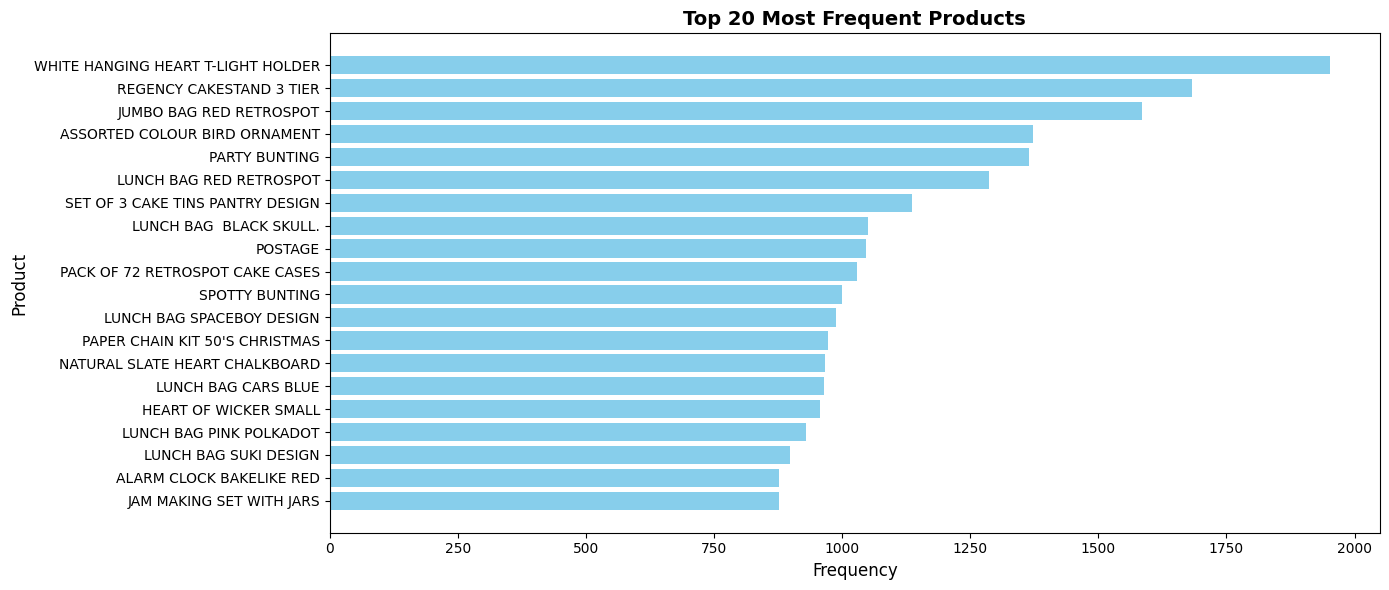

In [8]:
# Visualization 1: Top Frequent Items
print("="*60)
print("VISUALIZATIONS")
print("="*60)

# Convert to Pandas for visualization
freq_items_pd = frequent_itemsets.filter(size(col("items")) == 1) \
    .orderBy(col("freq").desc()) \
    .limit(20) \
    .toPandas()

# Extract item names
freq_items_pd['item'] = freq_items_pd['items'].apply(lambda x: x[0] if len(x) > 0 else '')

# Plot top 20 frequent items
plt.figure(figsize=(14, 6))
plt.barh(freq_items_pd['item'], freq_items_pd['freq'], color='skyblue')
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Product', fontsize=12)
plt.title('Top 20 Most Frequent Products', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

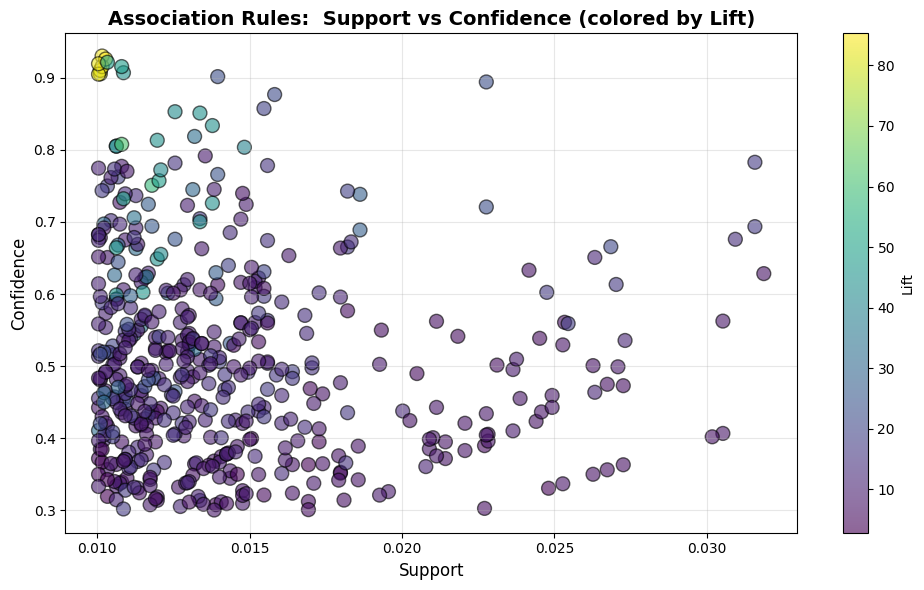

In [9]:
# Visualization 2: Support vs Confidence Scatter Plot
rules_pd = association_rules.limit(500).toPandas()

plt.figure(figsize=(10, 6))
scatter = plt.scatter(rules_pd['support'], rules_pd['confidence'],
                     c=rules_pd['lift'], cmap='viridis',
                     s=100, alpha=0.6, edgecolors='black')
plt.colorbar(scatter, label='Lift')
plt.xlabel('Support', fontsize=12)
plt.ylabel('Confidence', fontsize=12)
plt.title('Association Rules:  Support vs Confidence (colored by Lift)',
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

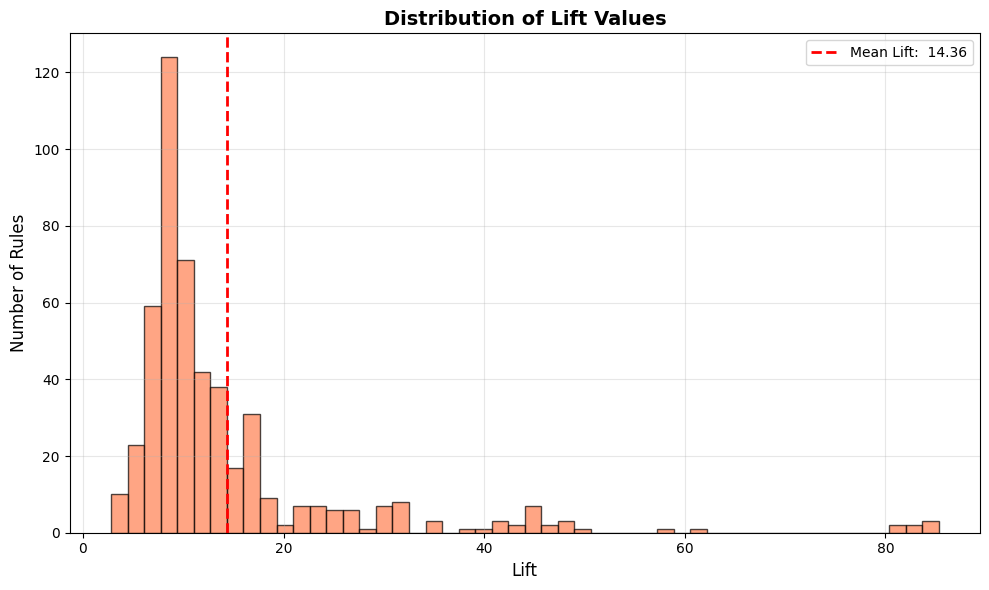

In [10]:
# Visualization 3: Lift Distribution
plt.figure(figsize=(10, 6))
plt.hist(rules_pd['lift'], bins=50, color='coral', edgecolor='black', alpha=0.7)
plt.xlabel('Lift', fontsize=12)
plt.ylabel('Number of Rules', fontsize=12)
plt.title('Distribution of Lift Values', fontsize=14, fontweight='bold')
plt.axvline(rules_pd['lift'].mean(), color='red', linestyle='--',
            linewidth=2, label=f'Mean Lift:  {rules_pd["lift"].mean():.2f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

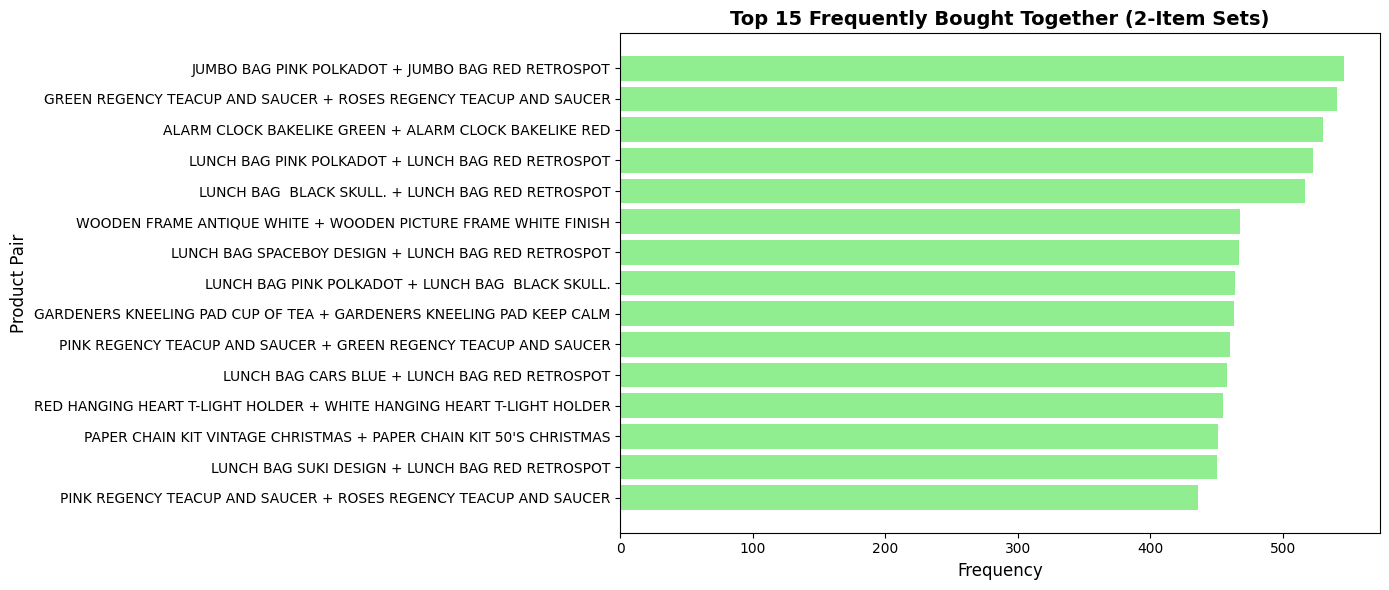

In [11]:
# Visualization 4: Top Product Pairs (2-itemsets)
freq_pairs = frequent_itemsets.filter(size(col("items")) == 2) \
    .orderBy(col("freq").desc()) \
    .limit(15) \
    .toPandas()

freq_pairs['pair'] = freq_pairs['items']. apply(lambda x: ' + '.join(x))

plt.figure(figsize=(14, 6))
plt.barh(freq_pairs['pair'], freq_pairs['freq'], color='lightgreen')
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Product Pair', fontsize=12)
plt.title('Top 15 Frequently Bought Together (2-Item Sets)',
          fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [13]:
# Business Insights and Recommendations
print("="*60)
print("BUSINESS INSIGHTS & RECOMMENDATIONS")
print("="*60)

# 1. Product Bundling Opportunities
print("\n1. TOP PRODUCT BUNDLING OPPORTUNITIES:")
print("-" * 60)
bundling_rules = association_rules.filter(
    (col("confidence") > 0.5) &
    (col("lift") > 2)
).orderBy(col("lift").desc()).limit(10)

bundling_pd = bundling_rules.toPandas()
for idx, row in bundling_pd.iterrows():
    antecedent = ', '.join(row['antecedent'])
    consequent = ', '.join(row['consequent'])
    print(f"\nRule {idx+1}:  If customer buys [{antecedent}]")
    print(f"         → They will likely buy [{consequent}]")
    print(f"         Confidence: {row['confidence']:.2%}, Lift: {row['lift']:.2f}")

# 2. Cross-Selling Strategies
print("\n\n2. CROSS-SELLING STRATEGIES:")
print("-" * 60)
cross_sell_rules = association_rules.filter(
    size(col("antecedent")) == 1
).orderBy(col("confidence").desc()).limit(10)

cross_sell_pd = cross_sell_rules.toPandas()
for idx, row in cross_sell_pd.iterrows():
    antecedent = row['antecedent'][0]
    consequent = ', '.join(row['consequent'])
    print(f"\n{idx+1}. When customer buys:  {antecedent}")
    print(f"   Recommend: {consequent}")
    print(f"   Success Rate: {row['confidence']:.2%}") # Fixed: Removed space after colon

# 3. Product Placement Recommendations
print("\n\n3. PRODUCT PLACEMENT RECOMMENDATIONS:")
print("-" * 60)
print("Based on association rules, consider placing these products near each other:")

placement_rules = strong_rules.limit(5).toPandas()
for idx, row in placement_rules.iterrows():
    items = list(row['antecedent']) + list(row['consequent'])
    print(f"\n{idx+1}. Group:  {' <-> '.join(items)}")
    print(f"   Rationale: Lift = {row['lift']:.2f} (Strong association)")

BUSINESS INSIGHTS & RECOMMENDATIONS

1. TOP PRODUCT BUNDLING OPPORTUNITIES:
------------------------------------------------------------

Rule 1:  If customer buys [HERB MARKER ROSEMARY]
         → They will likely buy [HERB MARKER THYME]
         Confidence: 92.63%, Lift: 85.31

Rule 2:  If customer buys [HERB MARKER THYME]
         → They will likely buy [HERB MARKER ROSEMARY]
         Confidence: 94.62%, Lift: 85.31

Rule 3:  If customer buys [HERB MARKER PARSLEY]
         → They will likely buy [HERB MARKER ROSEMARY]
         Confidence: 93.05%, Lift: 83.89

Rule 4:  If customer buys [HERB MARKER ROSEMARY]
         → They will likely buy [HERB MARKER PARSLEY]
         Confidence: 91.58%, Lift: 83.89

Rule 5:  If customer buys [HERB MARKER BASIL]
         → They will likely buy [HERB MARKER ROSEMARY]
         Confidence: 91.98%, Lift: 82.93

Rule 6:  If customer buys [HERB MARKER ROSEMARY]
         → They will likely buy [HERB MARKER BASIL]
         Confidence: 90.53%, Lift: 82.93

